In [1]:
import random
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchtext import data 

from utils import *
from transformers import BertTokenizer

# Ref: https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

SEED = 42
BATCH_SIZE = 32
HIDDEN_DIM = 256
OUTPUT_DIM = 3
# OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.25
MAX_EPOCHS = 3
LEARN_RATE = 3e-5
WEIGHT_DECAY = 0
BATCH_LOG_INTERVAL = 100

# BERT_N = 'bert-base-uncased'
BERT_N = 'bert-base-uncased'

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
tokenizer = BertTokenizer.from_pretrained(BERT_N)

# News

In [4]:
news = pd.read_pickle('data.pkl').sample(15000, random_state=SEED)
classifier = SentimentIntensityAnalyzer()
news['scores'] = news['sentences'].apply(lambda x: to_sentiment(classifier, x))

X_train, X_val_test = train_test_split(news, test_size=0.4, random_state=SEED)
X_val, X_test = train_test_split(X_val_test, test_size=0.5, random_state=SEED)

max_input_length = 100
# max_input_length = tokenizer.max_model_input_sizes[BERT_N]
train_loader = package_data(X_train, tokenizer, max_input_length, BATCH_SIZE)
val_loader = package_data(X_val, tokenizer, max_input_length, BATCH_SIZE)
test_loader = package_data(X_test, tokenizer, max_input_length, BATCH_SIZE)

# model = BertSentimentAnalyzer(OUTPUT_DIM, DROPOUT).to(device)
model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels=3,
            output_attentions=False,
            output_hidden_states=False
        ).to(device)
optimizer = optim.Adam(model.parameters(),
                        lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
loss = nn.CrossEntropyLoss().to(device)
# loss = nn.BCEWithLogitsLoss().to(device)

In [5]:
#### Train and test autoencoder ####
train_loss = []
val_loss = []
for epoch in range(MAX_EPOCHS):
    train_loss.append(train(model, epoch, optimizer,
        train_loader, BATCH_LOG_INTERVAL,
        lossf=loss, device=device))
    val_loss.append(evaluate(model, epoch, val_loader,
        device=device, lossf=loss, is_val=True))
    
# checkpoint model
torch.save(model.state_dict(), 'newsmodel.pt')

====> Epoch: 0 Average loss: 0.0035
====> Val set loss: 0.0024
====> Epoch: 1 Average loss: 0.0013
====> Val set loss: 0.0032
====> Epoch: 2 Average loss: 0.0003
====> Val set loss: 0.0039


In [17]:
def get_predictions(model, data_loader, device):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d['sentence']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['label'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids=None)
            _, preds = torch.max(outputs[0], dim=1)

            probs = F.softmax(outputs[0], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

              precision    recall  f1-score   support

         neg       0.97      0.56      0.71        61
         neu       0.99      1.00      0.99      2913
         pos       0.58      0.42      0.49        26

    accuracy                           0.98      3000
   macro avg       0.85      0.66      0.73      3000
weighted avg       0.98      0.98      0.98      3000



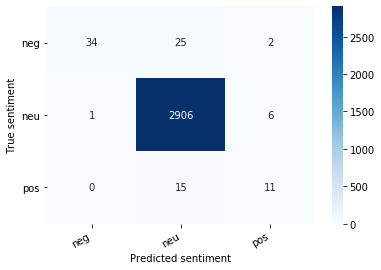

In [18]:
# news_model = BertSentimentAnalyzer(OUTPUT_DIM, DROPOUT)
news_model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels=3,
            output_attentions=False,
            output_hidden_states=False
        )
news_model.load_state_dict(torch.load('newsmodel.pt'))
news_model.to(device)
news_model.eval()

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    news_model,
    test_loader,
    device
)

class_names = ['neg', 'neu', 'pos']
print(classification_report(y_test, y_pred, labels=[0,1,2], target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# wikipedia 

In [19]:
wiki = pd.read_csv('train.tsv', sep='\t', names=['full','split'])['full'].sample(15000, random_state=SEED)

classifier = SentimentIntensityAnalyzer()
scores = wiki.apply(lambda x: to_sentiment(classifier, x))
wikidf = pd.concat([wiki, scores], axis=1)
wikidf.columns = ['sentences', 'scores']

X_train, X_val_test = train_test_split(wikidf, test_size=0.4, random_state=SEED)
X_val, X_test = train_test_split(X_val_test, test_size=0.5, random_state=SEED)

In [22]:
max_input_length = 100
# max_input_length = tokenizer.max_model_input_sizes[BERT_N]
train_loader = package_data(X_train, tokenizer, max_input_length, BATCH_SIZE)
val_loader = package_data(X_val, tokenizer, max_input_length, BATCH_SIZE)
test_loader = package_data(X_test, tokenizer, max_input_length, BATCH_SIZE)

# model = BertSentimentAnalyzer(OUTPUT_DIM, DROPOUT).to(device)
model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels=3,
            output_attentions=False,
            output_hidden_states=False
        ).to(device)
optimizer = optim.Adam(model.parameters(),
                        lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
loss = nn.CrossEntropyLoss().to(device)

train_loss = []
val_loss = []
for epoch in range(MAX_EPOCHS):
    train_loss.append(train(model, epoch, optimizer,
        train_loader, BATCH_LOG_INTERVAL,
        lossf=loss, device=device))
    val_loss.append(evaluate(model, epoch, val_loader,
        device=device, lossf=loss, is_val=True))
    
# checkpoint model
torch.save(model.state_dict(), 'wikimodel.pt')

====> Epoch: 0 Average loss: 0.0010
====> Val set loss: 0.0001
====> Epoch: 1 Average loss: 0.0001
====> Val set loss: 0.0001
====> Epoch: 2 Average loss: 0.0001
====> Val set loss: 0.0001


In [23]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_loader,
    device
)

class_names = ['neg', 'neu', 'pos']
print(classification_report(y_test, y_pred, labels=[0,1,2], target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

         neg       0.00      0.00      0.00         0
         neu       1.00      1.00      1.00      3000
         pos       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00      3000
   macro avg       0.33      0.33      0.33      3000
weighted avg       1.00      1.00      1.00      3000



/home/davina/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davina/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Shape of passed values is (1, 1), indices imply (3, 3)

# benchmark

In [24]:
# pd.read_csv('stanfordSentimentTreebank/datasetSentences.txt', sep='\t')
phrases = pd.read_csv('stanfordSentimentTreebank/dictionary.txt', sep='|', names=['phrase', 'phrase ids'])
sentiment = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', sep='|')
benchmark = phrases.join(sentiment, on='phrase ids', lsuffix="l")[['phrase', 'sentiment values']]
benchmark['sentiment values'] = benchmark['sentiment values'].apply(sst_threshold)
benchmark.columns = ['sentences', 'scores']
loader = package_data(benchmark, tokenizer, max_input_length, BATCH_SIZE)

              precision    recall  f1-score   support

         neg       0.00      0.00      0.00    119449
         neu       0.23      1.00      0.37     54380
         pos       0.25      0.00      0.00     65403

    accuracy                           0.23    239232
   macro avg       0.16      0.33      0.12    239232
weighted avg       0.12      0.23      0.08    239232



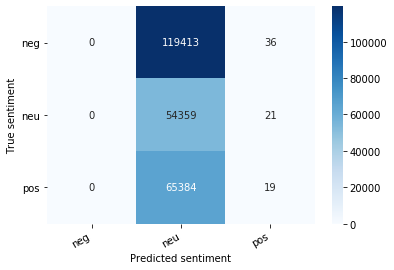

In [25]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    loader,
    device
)

class_names = ['neg', 'neu', 'pos']
print(classification_report(y_test, y_pred, labels=[0,1,2], target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

         neg       0.64      0.04      0.08    119449
         neu       0.24      0.94      0.38     54380
         pos       0.69      0.16      0.26     65403

    accuracy                           0.28    239232
   macro avg       0.52      0.38      0.24    239232
weighted avg       0.56      0.28      0.20    239232



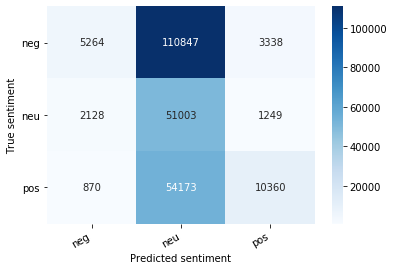

In [27]:
# news_model = BertSentimentAnalyzer(OUTPUT_DIM, DROPOUT)
news_model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels=3,
            output_attentions=False,
            output_hidden_states=False
        )
news_model.load_state_dict(torch.load('newsmodel.pt'))
news_model.to(device)
news_model.eval()

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    news_model,
    loader,
    device
)

class_names = ['neg', 'neu', 'pos']
print(classification_report(y_test, y_pred, labels=[0,1,2], target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)